194.71875


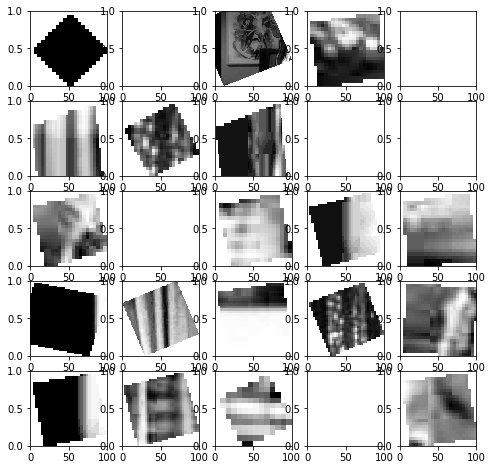

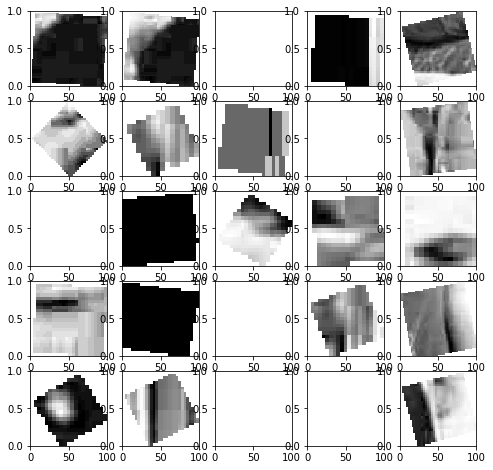

In [3]:
import glob
import random
import numpy as np
from sklearn.cluster import KMeans
import time
import scipy.io
from getPatchFromSIFTParameters import getPatchFromSIFTParameters
from dist2 import dist2
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm
import os

#Helper Functions
def getSample(sample_size, sift_path, frames_path):
    current_dir = os.getcwd()
    list_files = glob.glob(current_dir + frames_path)
    idx = np.arange(60, len(list_files))
    random.seed(101)
    random.shuffle(idx)
    selected_idx = idx[: sample_size]
    selected_frames = [list_files[i] for i in selected_idx]

    list_files_sift = glob.glob(current_dir + sift_path)
    selected_sift = [list_files_sift[i-59] for i in selected_idx]
    
    return selected_frames, selected_sift

def getDataFromMat(path):
    mat_file = scipy.io.loadmat(path)
    return mat_file['descriptors'], mat_file['positions'], mat_file['scales'], mat_file['orients']

def getDataArray(selected_sift):
    data_file_map = {}
    desc_list = np.asarray([])
    
    for mat_file in selected_sift:
        
        desc, pos, scales, orients = getDataFromMat(mat_file)
        init = np.shape(desc_list)[0]
        
        if mat_file == selected_sift[0]:
            desc_list = np.copy(desc)
        else:
            desc_list = np.concatenate((desc_list, desc), axis = 0) 
        end = np.shape(desc_list)[0]
        
        for i in range(init, end):
            data_file_map[i] = (mat_file, desc[i -init], pos[i-init], scales[i-init], orients[i-init])
            
    return desc_list, data_file_map

def getKCenters(k, data):
    start = time.process_time()    
    kmeans = KMeans(n_clusters=k, random_state= 101).fit(data)
    print(time.process_time() - start)
    np.save("vocabulary.npy", kmeans.cluster_centers_)
    return kmeans.cluster_centers_, kmeans.labels_

def display_patches(word, threshold, centers, desc_array, sift_list, frames_list, data_file_map):

    da = dist2(np.reshape(centers[word,:], (1,128)) , desc_array)
    da = da / np.amax(da)
    ind = da[0].argsort()[:25]

    fig=plt.figure(figsize=(8, 8))

    for i in range(len(ind)):
        
        if data_file_map[ind[i]][3] > threshold:
            
            matf = data_file_map[ind[i]][0]
            idx = sift_list.index(str(matf))
            img_path = frames_list[idx]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
            mat_file = scipy.io.loadmat(matf)
            p = data_file_map[ind[i]][2]
            s = data_file_map[ind[i]][3]
            o = data_file_map[ind[i]][4]

            plot = getPatchFromSIFTParameters(p, s, o, img)
            fig.add_subplot(5, 5, i+1)
            plt.imshow(plot,  cmap = cm.Greys_r, extent=[0,100,0,1], aspect='auto')
            
    plt.show()
    
def visualVocabulary(sift_path, frames_path, k):
    
    n_samples = 100
    
    selected_frames, selected_sift = getSample(n_samples, sift_path, frames_path)
    desc_array, data_file_map  = getDataArray(selected_sift)

    centers, labels = getKCenters(k, desc_array)
    #Load vocabulary file
    # centers = np.load('vocabulary.npy')
    word1 = 12
    word2 = 19
    display_patches(word1, 0.2, centers, desc_array, selected_sift, selected_frames, data_file_map )
    display_patches(word2, 0.2, centers, desc_array, selected_sift, selected_frames, data_file_map )

k = 20
frames_path = "/PS4Frames/frames/*.jpeg"
sift_path = "/PS4SIFT/sift/*"
visualVocabulary(sift_path, frames_path, k)